In [1]:
%pip install tensorflow_io

Note: you may need to restart the kernel to use updated packages.


In [103]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np

## Load Audio to Jupyter

In [104]:


def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate.numpy()

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        # speaker_id,version,gender,age,reason = speaker.split("-")
        #sp = speaker.split("-")
        #speaker_id = sp[0]
        #gender = sp[2]
        #age =sp[3]


        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate])
        #dataset.append([waveform, sample_rate, label, speaker_id, gender,age])

    return dataset



## Prepare Data

In [105]:
trainset_speechcommands_hungry = load_audio_files('./data/hungry', 'hungry')
trainset_speechcommands_burping = load_audio_files('./data/burping', 'burping')
trainset_speechcommands_tired = load_audio_files('./data/tired', 'tired')
trainset_speechcommands_belly_pain = load_audio_files('./data/belly_pain', 'belly_pain')
trainset_speechcommands_discomfort = load_audio_files('./data/discomfort', 'discomfort')
print(f'Length of hungry dataset: {len(trainset_speechcommands_hungry)}')
print(f'Length of tire dataset: {len(trainset_speechcommands_burping)}')
print(f'Length of tire dataset: {len(trainset_speechcommands_tired)}')
print(f'Length of tire dataset: {len(trainset_speechcommands_belly_pain)}')
print(f'Length of tire dataset: {len(trainset_speechcommands_discomfort)}')

Length of hungry dataset: 382
Length of tire dataset: 8
Length of tire dataset: 24
Length of tire dataset: 16
Length of tire dataset: 27


In [106]:
hungry_waveform = trainset_speechcommands_hungry[0][0]
hungry_sample_rate = trainset_speechcommands_hungry[0][1]
print(f'Yes Waveform: {hungry_waveform}')
print(f'Yes Sample Rate: {hungry_sample_rate}')
#print(f'Yes Label: {trainset_speechcommands_hungry[0][2]}')
#print(f'Yes ID: {trainset_speechcommands_hungry[0][3]}')

Yes Waveform: [ 0.          0.          0.         ... -0.0163269  -0.02514648
 -0.02832031]
Yes Sample Rate: 8000


## Waveform plot

In [107]:
timescale = np.arange(hungry_waveform .shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, hungry_waveform .numpy())
plt.show()

In [108]:
print(tf.shape(hungry_waveform))

tf.Tensor([53760], shape=(1,), dtype=int32)


## Spectrogram

In [109]:
def get_spectrogram(waveform):

    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    # zero_padding = tf.zeros([56000] - tf.shape(waveform), dtype=tf.float32)
    zero_padding = tf.zeros([60000] - tf.shape(waveform), dtype=tf.float32)
    
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [110]:
spectrogram, spect = get_spectrogram(hungry_waveform)

print('Label:', '้hungry')
print('Waveform shape:', hungry_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Spect shape:', spect.shape)
print('Audio playback')
ipd.Audio(hungry_waveform.numpy(), rate=8000)

Label: ้hungry
Waveform shape: (53760,)
Spectrogram shape: (467, 129)
Spect shape: (469, 128)
Audio playback


C:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


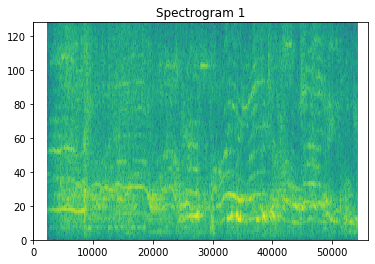

In [111]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 56000])
    ax.set_title(title)

fig, ax = plt.subplots()
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
plt.show()

fig, ax = plt.subplots()
plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
plt.show()

##  Create Spectrogram image for classification

In [112]:
def create_images(dataset, label_dir):
    # make directory
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):

        waveform = data[0]
        spectrogram, spect = get_spectrogram(waveform)

        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')



In [113]:
create_images(trainset_speechcommands_hungry, 'hungry')
create_images(trainset_speechcommands_tired, 'tired')
create_images(trainset_speechcommands_burping, 'burping')
create_images(trainset_speechcommands_discomfort, 'discomfort')
create_images(trainset_speechcommands_belly_pain, 'belly_pain')

### Build the model

In [114]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=0.3, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 5 classes.
Using 90 files for validation.
Found 154 files belonging to 5 classes.
['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']


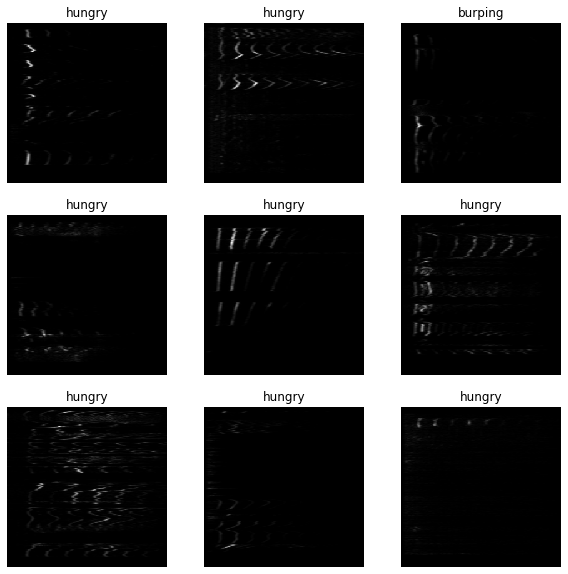

In [115]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create Model

In [100]:
num_classes = 5
img_height = 256
img_width = 256

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [116]:
learning_rate =  0.002

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate)
optimizer = tf.keras.optimizers.Adamax(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [117]:
# Set the epocks
epochs = 300
print('\nFitting:')
class_weights = {0:20, 1:30, 2:20, 3:1, 4:15}
# Train the model.
history = model.fit(train_ds, epochs=epochs,class_weight = class_weights)


Fitting:
Epoch 1/300
3/3 [==============================] - 3s 882ms/step - loss: 0.5100 - accuracy: 0.9889
Epoch 2/300
3/3 [==============================] - 3s 884ms/step - loss: 0.3628 - accuracy: 0.9889
Epoch 3/300
3/3 [==============================] - 3s 889ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 4/300
3/3 [==============================] - 3s 869ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 5/300
3/3 [==============================] - 3s 873ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 6/300
3/3 [==============================] - 3s 867ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/300
3/3 [==============================] - 3s 869ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 8/300
3/3 [==============================] - 3s 872ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 9/300
3/3 [==============================] - 3s 871ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 10/300
3/3 [==============================] - 3s 874ms/step - loss: 0.0026 - accuracy: 1.0000

3/3 [==============================] - 3s 872ms/step - loss: 2.2517e-08 - accuracy: 1.0000
Epoch 81/300
3/3 [==============================] - 3s 866ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 82/300
3/3 [==============================] - 3s 870ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 83/300
3/3 [==============================] - 3s 863ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 84/300
3/3 [==============================] - 3s 869ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 85/300
3/3 [==============================] - 3s 865ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 86/300
3/3 [==============================] - 3s 862ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 87/300
3/3 [==============================] - 3s 866ms/step - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 88/300
3/3 [==============================] - 3s 862ms/step - loss: 1.9868e-08 - accuracy: 1.0000
Epoch 89/300
3/3 [==============================] - 3s 872ms/step - loss: 1.9

3/3 [==============================] - 3s 869ms/step - loss: 5.8280e-08 - accuracy: 1.0000
Epoch 159/300
3/3 [==============================] - 3s 868ms/step - loss: 1.7219e-08 - accuracy: 1.0000
Epoch 160/300
3/3 [==============================] - 3s 864ms/step - loss: 1.5895e-08 - accuracy: 1.0000
Epoch 161/300
3/3 [==============================] - 3s 863ms/step - loss: 1.4570e-08 - accuracy: 1.0000
Epoch 162/300
3/3 [==============================] - 3s 868ms/step - loss: 5.4306e-08 - accuracy: 1.0000
Epoch 163/300
3/3 [==============================] - 3s 861ms/step - loss: 1.4570e-08 - accuracy: 1.0000
Epoch 164/300
3/3 [==============================] - 3s 865ms/step - loss: 5.5631e-08 - accuracy: 1.0000
Epoch 165/300
3/3 [==============================] - 3s 865ms/step - loss: 1.4570e-08 - accuracy: 1.0000
Epoch 166/300
3/3 [==============================] - 3s 885ms/step - loss: 1.5895e-08 - accuracy: 1.0000
Epoch 167/300
3/3 [==============================] - 3s 863ms/step - 

3/3 [==============================] - 3s 865ms/step - loss: 1.4570e-08 - accuracy: 1.0000
Epoch 237/300
3/3 [==============================] - 3s 865ms/step - loss: 1.0596e-08 - accuracy: 1.0000
Epoch 238/300
3/3 [==============================] - 3s 866ms/step - loss: 7.9473e-09 - accuracy: 1.0000
Epoch 239/300
3/3 [==============================] - 3s 864ms/step - loss: 4.2386e-08 - accuracy: 1.0000
Epoch 240/300
3/3 [==============================] - 3s 869ms/step - loss: 2.6491e-09 - accuracy: 1.0000
Epoch 241/300
3/3 [==============================] - 3s 865ms/step - loss: 6.6227e-09 - accuracy: 1.0000
Epoch 242/300
3/3 [==============================] - 3s 869ms/step - loss: 1.0596e-08 - accuracy: 1.0000
Epoch 243/300
3/3 [==============================] - 3s 869ms/step - loss: 9.2718e-09 - accuracy: 1.0000
Epoch 244/300
3/3 [==============================] - 3s 864ms/step - loss: 3.9736e-09 - accuracy: 1.0000
Epoch 245/300
3/3 [==============================] - 3s 870ms/step - 

In [118]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 128)     18560     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)       

In [119]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')

predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 0
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 4
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 0
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 4
predicted 3, actual 2
predicted 3, actual 3
predicted 4, actual 3
predicted 3, actual 3
predicted 0, actual 1
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 4
predicted 3, actual 3
predicted 3, actual 3
predicted 3, actual 4
predicted 3, actual 3
predicted 3, actual 4
predicted 3, actual 3
predicted 3, actual 3
Number correct: 22 out of 32
Accuracy 0.6875
